## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import tensorflow as tf
from wordcloud import WordCloud
from collections import Counter
import itertools
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from torch.utils.data import Dataset
from tabulate import tabulate
from scipy.stats import spearmanr
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

## Load Dataset
#### Here I have used Large Movie Review Dataset from Hugging Face. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. They provide a set of 25,000 reviews for training, and 25,000 for testing.

In [2]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/Kwaai/IMDB_Sentiment/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Kwaai/IMDB_Sentiment/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Data Preprocessing

In [3]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning
df_train["text"] = df_train["text"].apply(clean_text)
df_test["text"] = df_test["text"].apply(clean_text)

## Data Visualization

### 1. Class Distribution

<ipython-input-4-3b32490aaa68>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train["label"], palette="viridis")


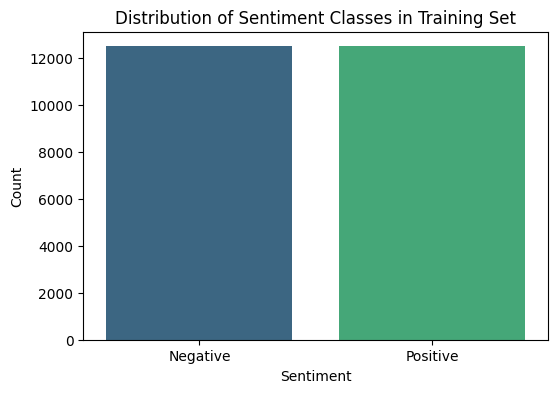

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_train["label"], palette="viridis")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Classes in Training Set")
plt.show()

### 2. Word Cloud for Positive and Negative Reviews

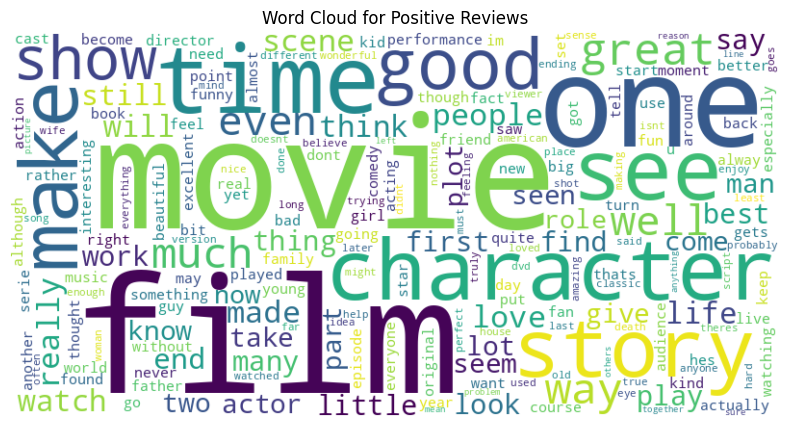

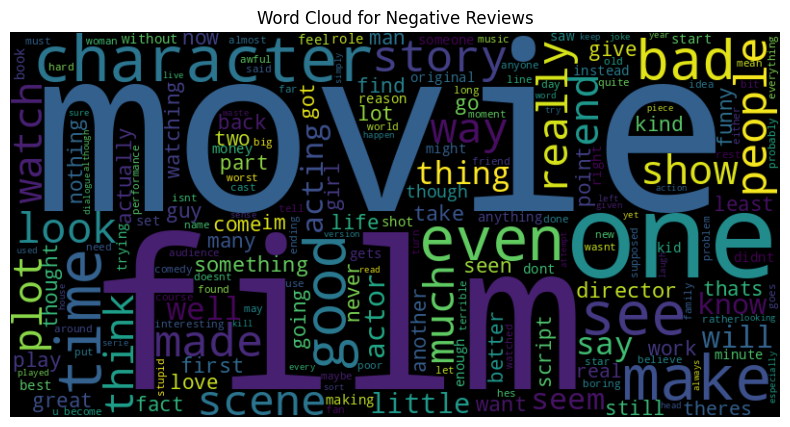

In [5]:
positive_text = " ".join(df_train[df_train["label"] == 1]["text"])
negative_text = " ".join(df_train[df_train["label"] == 0]["text"])

# Word Cloud for Positive Reviews
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

# Word Cloud for Negative Reviews
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(negative_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

### 3. Most common 20 words in the Dataset

<ipython-input-6-49da4c45f04f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="magma")


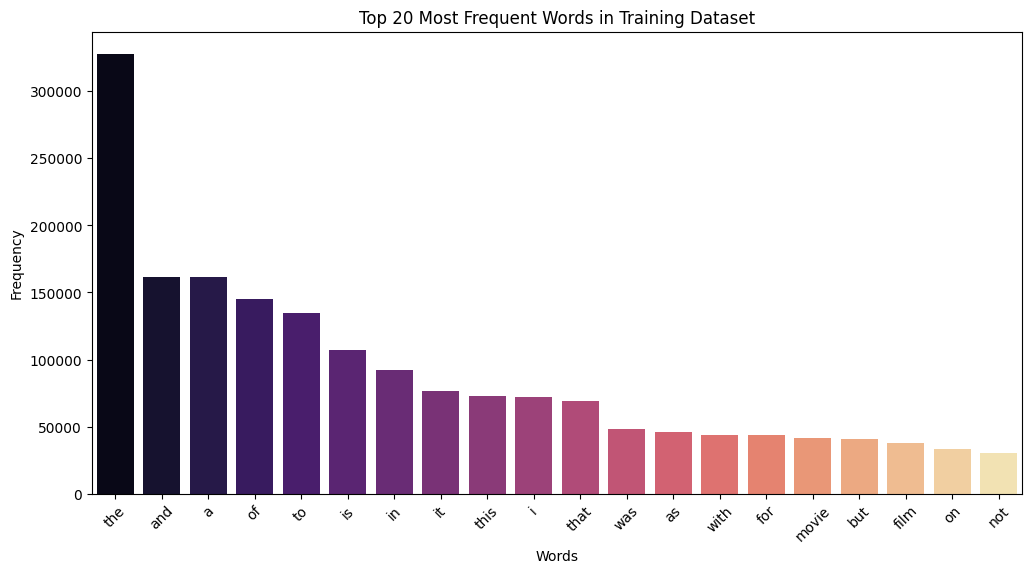

In [6]:
all_words = " ".join(df_train["text"]).split()
word_counts = Counter(all_words)

# the 20 most common words
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

# Plot word frequency
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), palette="magma")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Training Dataset")
plt.show()

### 4. Top 20 Most common Bigrams(Two word phrases) and Trigrams(Three word phrases)
#### Words that helps in understanding which word combinations are most relevant in sentiment analysis.

<ipython-input-7-687aeeab151e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigrams), y=list(bigram_counts), palette="Blues_r")


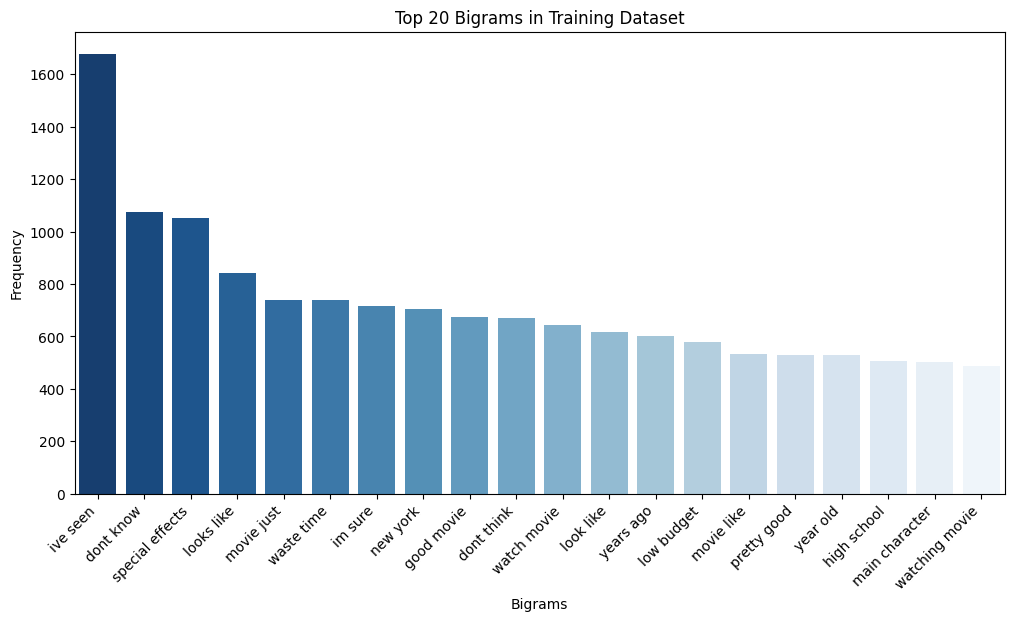

<ipython-input-7-687aeeab151e>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(trigrams), y=list(trigram_counts), palette="Greens_r")


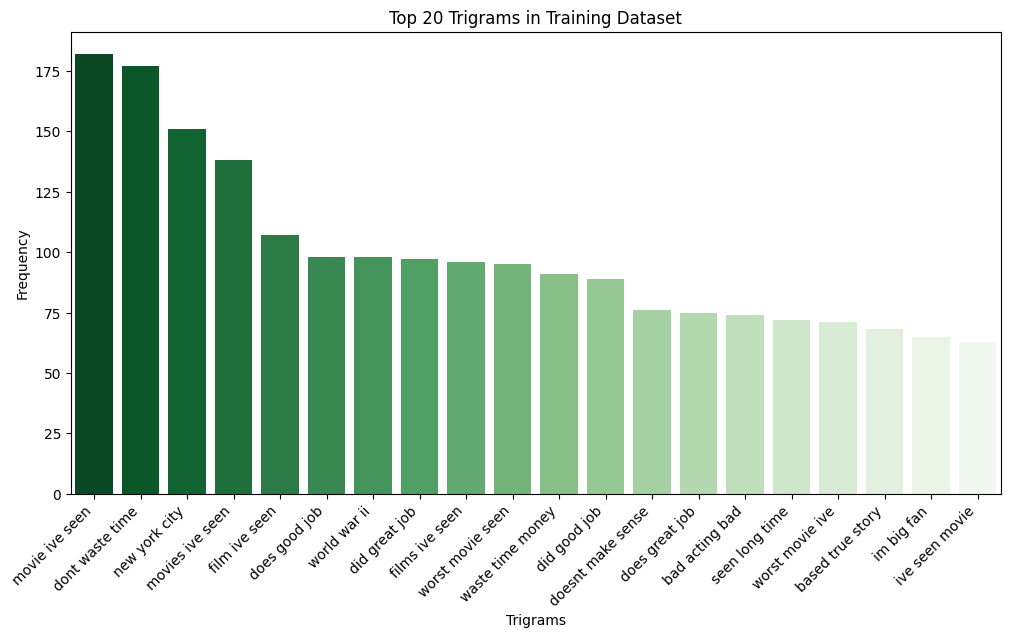

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# top n-grams (bigrams and trigrams)
def get_top_ngrams(corpus, ngram_range=(2, 2), n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words="english")
    ngram_counts = vectorizer.fit_transform(corpus)
    ngram_freq = np.asarray(ngram_counts.sum(axis=0)).flatten()

    ngram_features = vectorizer.get_feature_names_out()
    ngram_freq_dict = dict(zip(ngram_features, ngram_freq))

    return sorted(ngram_freq_dict.items(), key=lambda x: x[1], reverse=True)[:n]

# top bigrams and trigrams
top_bigrams = get_top_ngrams(df_train["text"], ngram_range=(2, 2), n=20)
top_trigrams = get_top_ngrams(df_train["text"], ngram_range=(3, 3), n=20)

# Plot bigrams
bigrams, bigram_counts = zip(*top_bigrams)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(bigrams), y=list(bigram_counts), palette="Blues_r")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Bigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Bigrams in Training Dataset")
plt.show()

# Plot trigrams
trigrams, trigram_counts = zip(*top_trigrams)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(trigrams), y=list(trigram_counts), palette="Greens_r")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Trigrams")
plt.ylabel("Frequency")
plt.title("Top 20 Trigrams in Training Dataset")
plt.show()



### 5. Top 20 High TF-IDF Scored words
#### Words that are most relevant in the dataset and helps understand which terms are most influential in sentiment prediction.

<ipython-input-8-8432ecbf0e9f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_features, y=sorted_scores, palette="Reds_r")


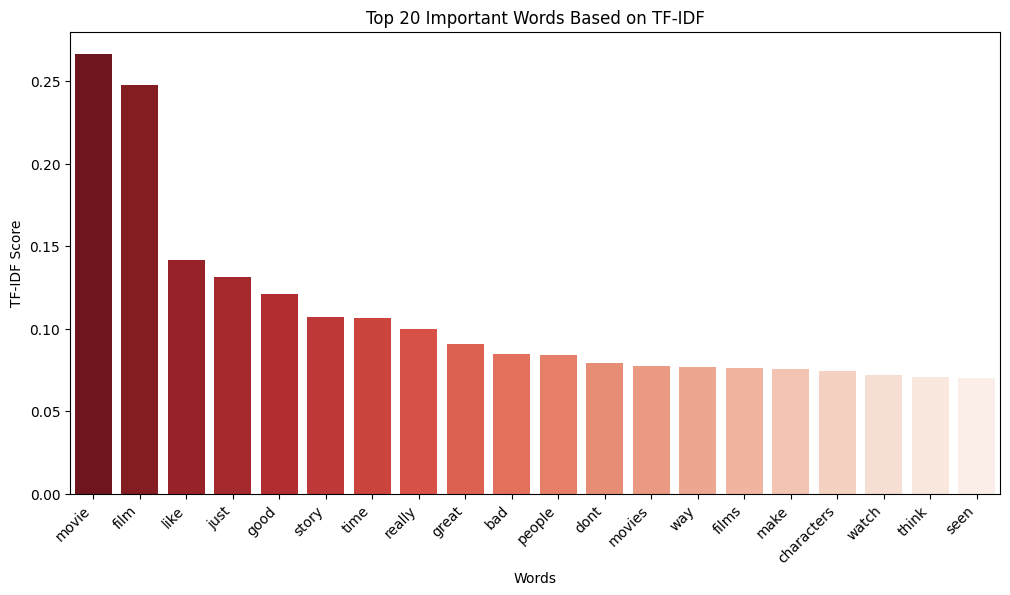

In [8]:
# Define TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=20, stop_words="english")
X_tfidf = vectorizer.fit_transform(df_train["text"])

# feature names and importance scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()

# Sort by importance
sorted_indices = np.argsort(tfidf_scores)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_scores = tfidf_scores[sorted_indices]

# Plot top TF-IDF words
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_features, y=sorted_scores, palette="Reds_r")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.title("Top 20 Important Words Based on TF-IDF")
plt.show()

### 6. Correlation Analysis between Word(Top 20) and Sentiment

<ipython-input-9-1d6b08c1d27b>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(correlations), palette="coolwarm")


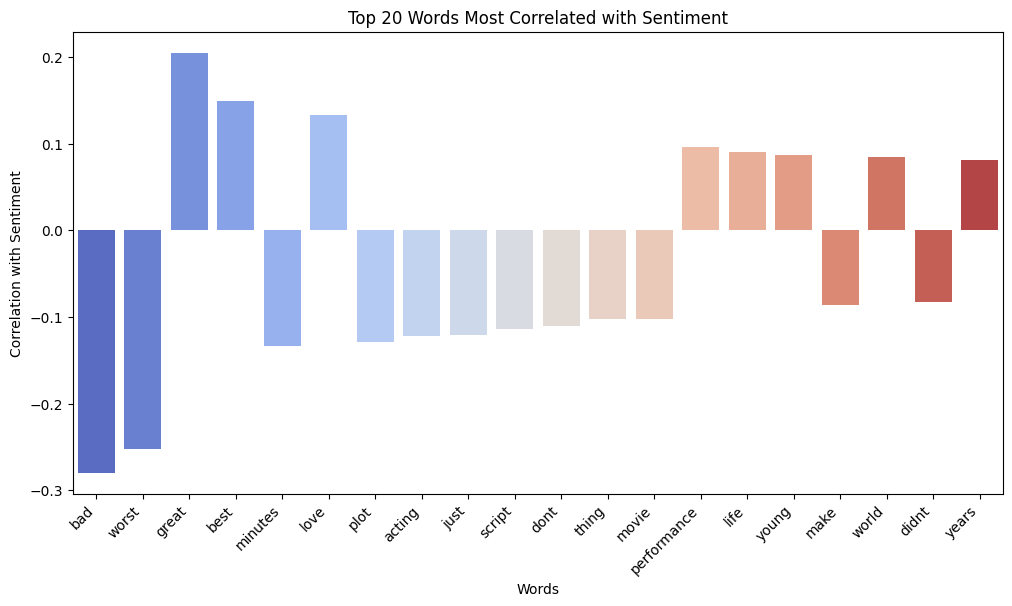

In [9]:
# Convert labels to numerical format (0 for Negative, 1 for Positive)
y_numeric = df_train["label"].values

# Compute TF-IDF for top 100 words
vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
X_tfidf = vectorizer.fit_transform(df_train["text"])

# Compute correlation between TF-IDF scores and sentiment labels
correlation_scores = []
feature_names = vectorizer.get_feature_names_out()

for i in range(len(feature_names)):
  word_tfidf = X_tfidf[:, i].toarray().flatten()
  correlation, _ = spearmanr(word_tfidf, y_numeric)
  correlation_scores.append((feature_names[i], correlation))

# Sort words by absolute correlation strength
correlation_scores = sorted(correlation_scores, key=lambda x: abs(x[1]), reverse=True)[:20]

# Extract words and their correlation values
words, correlations = zip(*correlation_scores)

# Plot correlation between words and sentiment labels
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(correlations), palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Words")
plt.ylabel("Correlation with Sentiment")
plt.title("Top 20 Words Most Correlated with Sentiment")
plt.show()

## Data Preparation for Model Implementation

In [10]:
# Separate features & labels
X_train, y_train = df_train["text"], df_train["label"]
X_test, y_test = df_test["text"], df_test["label"]

# Vectorization (TF-IDF for NB & SVM)
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words="english", max_features=20000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Tokenization & Padding (for LSTM)
vocab_size = 20000
max_length = 400

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

# Training
## 1. Naive Bayes

In [11]:
# Train Naïve Bayes
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

# Predictions
nb_preds = nb_model.predict(X_test_tfidf)

# Accuracy & Report
nb_acc = accuracy_score(y_test, nb_preds)
print(f"Naïve Bayes Accuracy: {nb_acc:.4f}\n")
print(classification_report(y_test, nb_preds))

Naïve Bayes Accuracy: 0.8482

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     12500
           1       0.86      0.83      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



### NB Learning Curve

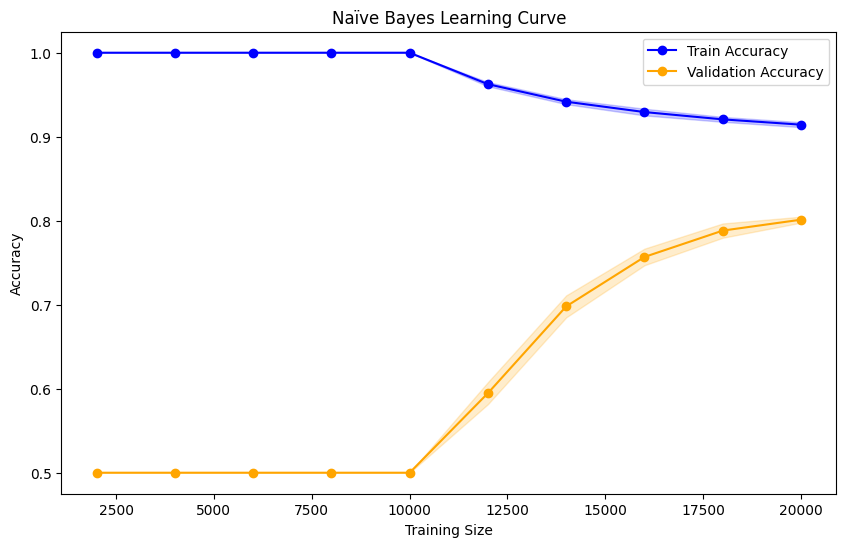

In [12]:
# Define function to plot learning curve
def plot_learning_curve(model, X, y, title="Learning Curve - Naïve Bayes"):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Train Accuracy", color="blue")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

    plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy", color="orange")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")

    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

# Train Naïve Bayes and plot learning curve
nb_model = MultinomialNB(alpha=0.1)
plot_learning_curve(nb_model, X_train_tfidf, y_train, title="Naïve Bayes Learning Curve")


### NB Confusion Matrix

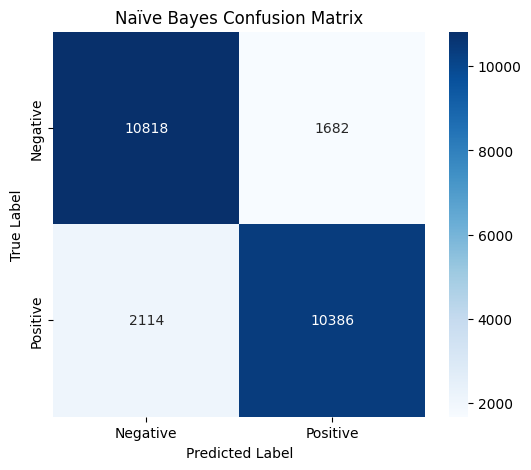

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, nb_preds)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naïve Bayes Confusion Matrix")
plt.show()

## 2. LSTM



In [14]:
# Define LSTM Model with Increased Regularization
lstm_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02))),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.02))),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1, activation='sigmoid')
])

# Compile Model with Reduced Learning Rate
optimizer = AdamW(learning_rate=0.0002, weight_decay=1e-5)
lstm_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks with Adjusted Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

# Train the Model
history = lstm_model.fit(
    X_train_seq, y_train,
    epochs=15, batch_size=64,
    validation_data=(X_test_seq, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate
test_loss, test_acc = lstm_model.evaluate(X_test_seq, y_test)
print(f"LSTM Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.5212 - loss: 11.1346 - val_accuracy: 0.5087 - val_loss: 5.3556 - learning_rate: 2.0000e-04
Epoch 2/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 815s 2s/step - accuracy: 0.7722 - loss: 4.3258 - val_accuracy: 0.8501 - val_loss: 2.4980 - learning_rate: 2.0000e-04
Epoch 3/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.8938 - loss: 2.1078 - val_accuracy: 0.8641 - val_loss: 1.4904 - learning_rate: 2.0000e-04
Epoch 4/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.9229 - loss: 1.1981 - val_accuracy: 0.8499 - val_loss: 1.0392 - learning_rate: 2.0000e-04
Epoch 5/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.9520 - loss: 0.6938 - val_accuracy: 0.8420 - val_loss: 0.8421 - learning_rate: 2.0000e-04
Epoch 6/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.9640 - loss: 0.4264 - val_accuracy: 0.6745 - val_loss: 1.6662 - learning_rate: 2.0000e-04
Epoch 7/15
391/391 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - ac

### LSTM Learning Curve

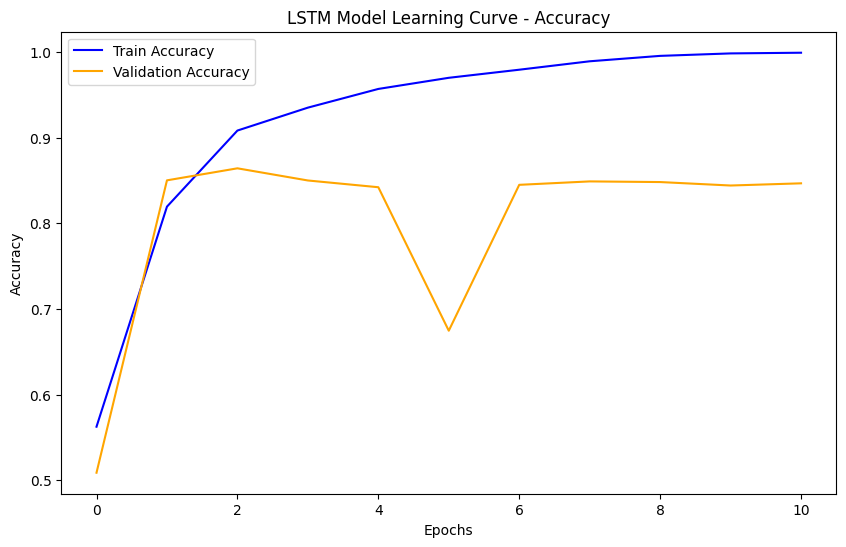

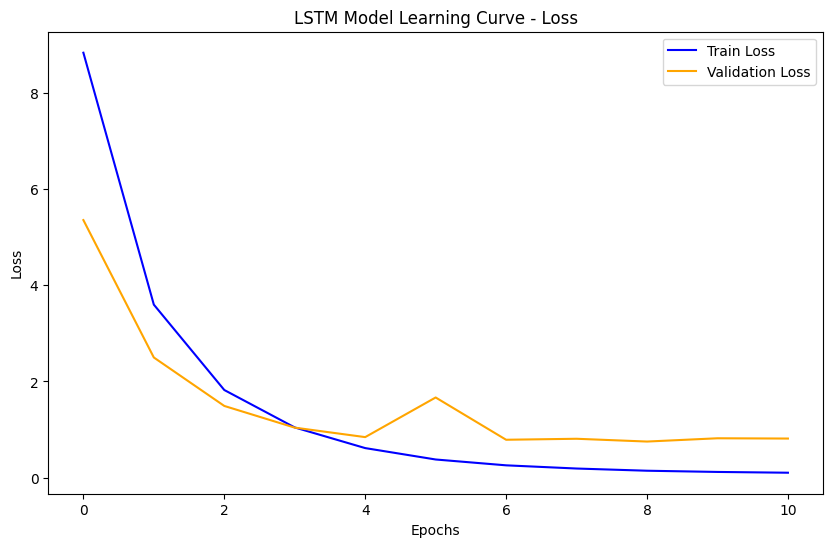

In [15]:
plt.figure(figsize=(10, 6))

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Model Learning Curve - Accuracy")
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Model Learning Curve - Loss")
plt.legend()
plt.show()

### LSTM Confusion Matrix

782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step


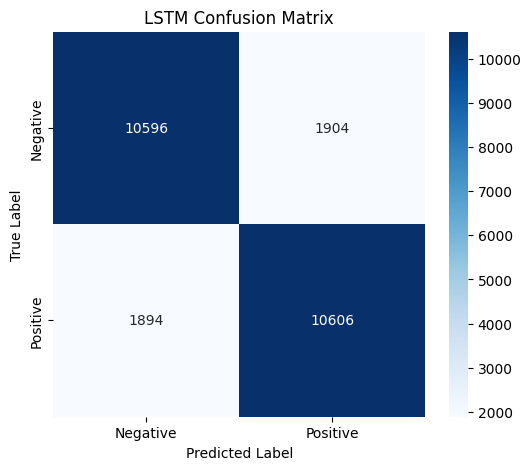

In [16]:
# Get predictions
y_pred_probs = lstm_model.predict(X_test_seq)  # Probabilities
y_preds = (y_pred_probs > 0.5).astype(int)  # Convert to binary labels

# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("LSTM Confusion Matrix")
plt.show()

## 3. SVM

In [17]:
# Train SVM Model
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
svm_preds = svm_model.predict(X_test_tfidf)

# Accuracy & Report
svm_acc = accuracy_score(y_test, svm_preds)
print(f"SVM Accuracy: {svm_acc:.4f}\n")
print(classification_report(y_test, svm_preds))

SVM Accuracy: 0.8771

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     12500
           1       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



### SVM Confusion Matrix

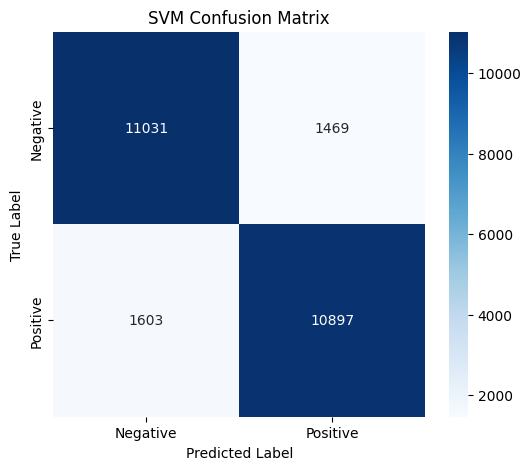

In [18]:
conf_matrix_svm = confusion_matrix(y_test, svm_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SVM Confusion Matrix")
plt.show()

## Result Summary

In [19]:
accuracy_data = [
    ["Naïve Bayes", f"{nb_acc:.4f}"],
    ["LSTM", f"{test_acc:.4f}"],
    ["SVM", f"{svm_acc:.4f}"]
]

print(tabulate(accuracy_data, headers=["Model", "Accuracy"], tablefmt="grid"))

+-------------+------------+
| Model       |   Accuracy |
+=============+============+
| Naïve Bayes |     0.8482 |
+-------------+------------+
| LSTM        |     0.8481 |
+-------------+------------+
| SVM         |     0.8771 |
+-------------+------------+
